In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, current_date, datediff, regexp_extract, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [1]:
file_path = "gs://my-bigdata-project-ma/cleaned/cleaned_itineraries.parquet"
df = spark.read.parquet(file_path)

In [4]:
df.select(
    ["searchDate", "flightDate", "startingAirport", "destinationAirport", 
     "travelDuration", "elapsedDays", "totalTravelDistance", "seatsRemaining"]
).where(datediff(df.flightDate, df.searchDate) > 5).sample(0.3, False).show(5)

+----------+----------+---------------+------------------+--------------+-----------+-------------------+--------------+
|searchDate|flightDate|startingAirport|destinationAirport|travelDuration|elapsedDays|totalTravelDistance|seatsRemaining|
+----------+----------+---------------+------------------+--------------+-----------+-------------------+--------------+
|2022-04-19|2022-05-29|            ORD|               MIA|       PT6H35M|          0|             1196.0|             9|
|2022-04-19|2022-05-29|            ORD|               MIA|        PT9H3M|          0|             1824.0|             9|
|2022-04-19|2022-05-29|            ORD|               MIA|        PT3H6M|          0|             1192.0|             2|
|2022-04-19|2022-05-29|            ORD|               MIA|       PT7H30M|          0|             1824.0|             7|
|2022-04-19|2022-05-29|            ORD|               MIA|       PT8H22M|          0|             1824.0|             7|
+----------+----------+---------

In [6]:
df = df.withColumn("travelduration_hours", regexp_extract(col("travelDuration"), r"(\d+)H", 1).cast("int"))
df = df.withColumn("travelduration_minutes", regexp_extract(col("travelDuration"), r"(\d+)M", 1).cast("int"))
df = df.na.fill(value=0.0, subset=["travelduration_minutes", "travelduration_hours"])
df = df.withColumn("travelduration_total_minutes", col("travelduration_hours") * 60 + col("travelduration_minutes"))

In [8]:
df.where(df.travelduration_total_minutes.isNull()) \
  .select(["travelDuration", "travelduration_hours", "travelduration_minutes", "travelduration_total_minutes"]) \
  .show(100)

+--------------+--------------------+----------------------+----------------------------+
|travelDuration|travelduration_hours|travelduration_minutes|travelduration_total_minutes|
+--------------+--------------------+----------------------+----------------------------+
+--------------+--------------------+----------------------+----------------------------+



In [9]:
indexer = StringIndexer(inputCols=["startingAirport", "destinationAirport"],
                        outputCols=["startingAirportIndex", "destinationAirportIndex"])
df = indexer.fit(df).transform(df)

In [10]:
df = df.withColumn("isBasicEconomyBinary", when(df.isBasicEconomy == True, 1.0).otherwise(0.0))
df = df.withColumn("isRefundableBinary", when(df.isRefundable == True, 1.0).otherwise(0.0))
df = df.withColumn("isNonStopBinary", when(df.isNonStop == True, 1.0).otherwise(0.0))

In [11]:
encoder = OneHotEncoder(
    inputCols=["startingAirportIndex", "destinationAirportIndex"],
    outputCols=["startingAirportVector", "destinationAirportVector"],
    dropLast=True, handleInvalid="keep"
)
df = encoder.fit(df).transform(df)

In [12]:
df = df.withColumn("seatsRemaining", df.seatsRemaining.cast('double'))
df = df.withColumn("totalTravelDistance", df.totalTravelDistance.cast('double'))
df = df.withColumn("travelduration_total_minutes", df.travelduration_total_minutes.cast('double'))

In [13]:
travelduration_assembler = VectorAssembler(inputCols=["travelduration_total_minutes"], outputCol="traveldurationVector", handleInvalid="skip")
distance_assembler = VectorAssembler(inputCols=["totalTravelDistance"], outputCol="distanceVector", handleInvalid="skip")

In [14]:
travelduration_scaler = MinMaxScaler(inputCol="traveldurationVector", outputCol="scaled_travelduration")
distance_scaler = MinMaxScaler(inputCol="distanceVector", outputCol="scaled_distance")

In [15]:
assembler = VectorAssembler(inputCols=["startingAirportVector", "destinationAirportVector", 
                                       "isBasicEconomyBinary", "isRefundableBinary", 
                                       "isNonStopBinary", "scaled_travelduration", 
                                       "seatsRemaining", "scaled_distance"],
                            outputCol="features")

In [16]:
df.select(["startingAirportVector", "destinationAirportVector", "isBasicEconomyBinary", 
           "isRefundableBinary", "isNonStopBinary", "travelduration_total_minutes", 
           "seatsRemaining", "totalTravelDistance"]).show(10)

+---------------------+------------------------+--------------------+------------------+---------------+----------------------------+--------------+-------------------+
|startingAirportVector|destinationAirportVector|isBasicEconomyBinary|isRefundableBinary|isNonStopBinary|travelduration_total_minutes|seatsRemaining|totalTravelDistance|
+---------------------+------------------------+--------------------+------------------+---------------+----------------------------+--------------+-------------------+
|       (16,[6],[1.0])|          (16,[7],[1.0])|                 0.0|               0.0|            0.0|                       740.0|           9.0|             1844.0|
|       (16,[6],[1.0])|          (16,[7],[1.0])|                 0.0|               0.0|            0.0|                       388.0|           9.0|             1824.0|
|       (16,[6],[1.0])|          (16,[7],[1.0])|                 0.0|               0.0|            0.0|                       395.0|           9.0|       

In [17]:
pipeline = Pipeline(stages=[travelduration_assembler, distance_assembler, 
                            travelduration_scaler, distance_scaler, assembler, LinearRegression(labelCol="totalFare")])

In [18]:
trainingData, testData = df.randomSplit([0.7, 0.3], seed=42)
model = pipeline.fit(trainingData)

predictions = model.transform(testData)

grid = ParamGridBuilder().build()

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=grid,
                    evaluator=RegressionEvaluator(labelCol='totalFare', metricName='rmse'),
                    numFolds=3)

all_models = cv.fit(trainingData)

print(f"Average RMSE: {all_models.avgMetrics}")
bestModel = all_models.bestModel

24/12/02 18:40:34 WARN Instrumentation: [cfe29ee0] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 18:43:22 WARN Instrumentation: [cfe29ee0] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/12/02 18:50:02 WARN Instrumentation: [a3d61438] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 18:50:39 WARN Instrumentation: [a3d61438] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/12/02 18:58:04 WARN Instrumentation: [819c7adb] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 18:58:38 WARN Instrumentation: [819c7adb] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/12/02 19:05:31 WARN Instrumentation: [c0ed7607] regParam is zero, which might cause numerical instability and overfitting.
24/12/02 19:06:05 WARN Instrumentation: [c0ed7607] Cholesky solv

Average RMSE: [149.1427279717236]


In [19]:
test_results = bestModel.transform(testData)
test_results.select(
    "startingAirport", "destinationAirport", "travelduration_total_minutes", 
    "seatsRemaining", "totalFare", "prediction", 
    "scaled_travelduration", "scaled_distance"
).show(truncate=False)

evaluator = RegressionEvaluator(labelCol='totalFare', metricName='rmse')
rmse = evaluator.evaluate(predictions)
r2_evaluator = RegressionEvaluator(labelCol="totalFare", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

+---------------+------------------+----------------------------+--------------+---------+------------------+---------------------+---------------------+
|startingAirport|destinationAirport|travelduration_total_minutes|seatsRemaining|totalFare|prediction        |scaled_travelduration|scaled_distance      |
+---------------+------------------+----------------------------+--------------+---------+------------------+---------------------+---------------------+
|LAX            |ORD               |248.0                       |7.0           |342.6    |338.9375827994736 |[0.17246175243393602]|[0.23118804969984644]|
|LAX            |ORD               |248.0                       |9.0           |428.6    |346.6121666999105 |[0.17246175243393602]|[0.23118804969984644]|
|CLT            |JFK               |112.0                       |7.0           |187.1    |286.0243399851679 |[0.07788595271210014]|[0.0636604774535809] |
|CLT            |JFK               |112.0                       |7.0        

RMSE: 149.07691461983964
R-squared: 0.42828966959337833


In [20]:
bestModel = all_models.bestModel
feature_importances = bestModel.stages[-1].coefficients

var_index = dict()
for variable_type in ['numeric', 'binary']:
    for variable in predictions.schema["features"].metadata["ml_attr"]["attrs"].get(variable_type, []):
        idx = variable['idx']
        name = variable['name']
        var_index[idx] = name 

for i in range(len(var_index)):
    print(f"Feature Importance {i}: {var_index[i]} - {feature_importances[i]}")

Feature Importance 0: startingAirportVector_LAX - -10.445565293730803
Feature Importance 1: startingAirportVector_LGA - -30.200708638761093
Feature Importance 2: startingAirportVector_BOS - -31.86023808443062
Feature Importance 3: startingAirportVector_SFO - 20.204837849281073
Feature Importance 4: startingAirportVector_CLT - 0.6421612106779777
Feature Importance 5: startingAirportVector_DFW - -20.10110433562152
Feature Importance 6: startingAirportVector_ORD - -9.229139155213245
Feature Importance 7: startingAirportVector_ATL - 0.11084123067824313
Feature Importance 8: startingAirportVector_DEN - -18.449362268297886
Feature Importance 9: startingAirportVector_MIA - -44.732670771408934
Feature Importance 10: startingAirportVector_JFK - 35.37234364559403
Feature Importance 11: startingAirportVector_PHL - 8.302884144067544
Feature Importance 12: startingAirportVector_DTW - 8.805149753105054
Feature Importance 13: startingAirportVector_EWR - -8.721725658700949
Feature Importance 14: start

In [23]:
sampled_df = df.sample(fraction=0.01, seed=42)

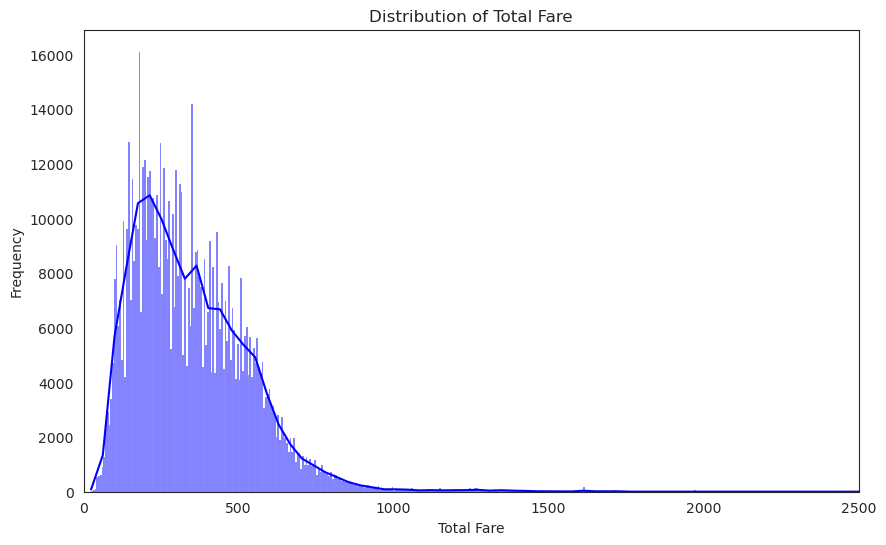

In [28]:
# Histogram Total fare distributions based on sample
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(sampled_df.toPandas()['totalFare'], kde=True, color='blue')
plt.title('Distribution of Total Fare')
plt.xlabel('Total Fare')
plt.ylabel('Frequency')
plt.xlim(0, 2500)  
plt.show()

In [31]:
# saving histogram
import io
from google.cloud import storage
img_data = io.BytesIO()

# save the figure to the buffer in png format
plt.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-bigdata-project-ma')
blob = bucket.blob("total_fare_distribution_plot.png")
blob.upload_from_file(img_data)
plt.close()

/tmp/ipykernel_11616/136627687.py:19: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='flightDate', y='avg(totalFare)', data=agg_data, palette='Blues')  # Use palette='Blues' for light blue


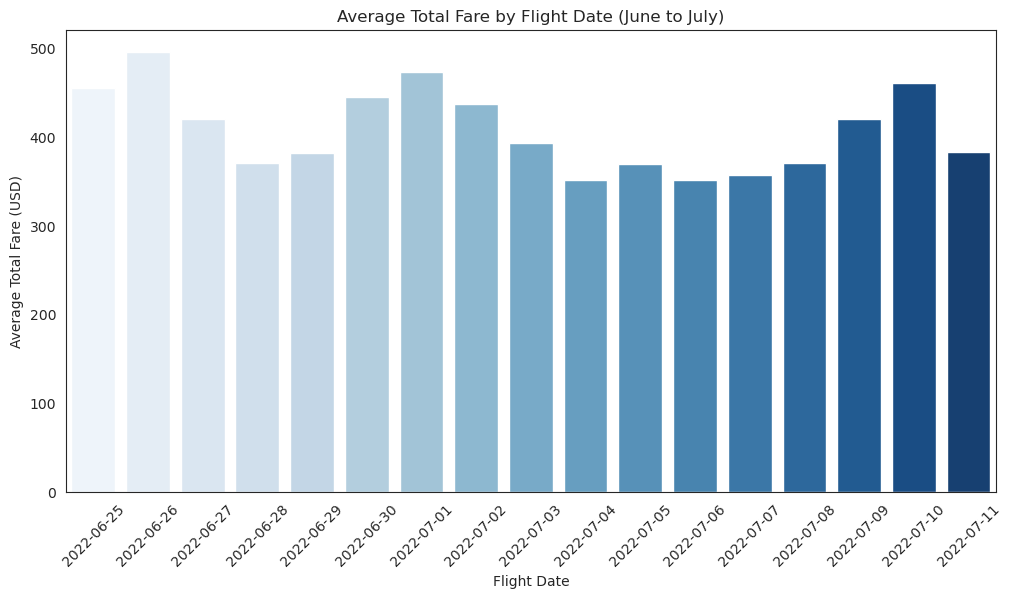

In [54]:
#total fare june-july bar graph
from pyspark.sql.functions import col

filtered_df = sampled_df.where((col('flightDate') >= '2022-06-25') & (col('flightDate') <= '2022-07-11'))
agg_data = filtered_df.groupBy('flightDate').agg({'totalFare': 'avg'}).toPandas()
agg_data['flightDate'] = pd.to_datetime(agg_data['flightDate'])

#sorting by flightDate in ascending order
agg_data = agg_data.sort_values('flightDate', ascending=True)

#plotting graph
plt.figure(figsize=(12, 6))
sns.barplot(x='flightDate', y='avg(totalFare)', data=agg_data, palette='Blues')
plt.title('Average Total Fare by Flight Date (June to July)')
plt.xlabel('Flight Date')
plt.ylabel('Average Total Fare (USD)')
plt.xticks(rotation=45)
plt.show()


In [55]:
img_data.seek(0)
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-bigdata-project-ma')
blob = bucket.blob("fare_by_flight_date_June_July_plot.png")
blob.upload_from_file(img_data)
plt.close()

24/12/02 21:42:58 WARN BlockManagerMasterEndpoint: No more replicas available for broadcast_159_piece0 !
24/12/02 21:42:58 WARN BlockManagerMaster: Failed to remove broadcast 159 with removeFromMaster = true - org.apache.spark.SparkException: Could not find BlockManagerEndpoint1.
	at org.apache.spark.rpc.netty.Dispatcher.postMessage(Dispatcher.scala:178)
	at org.apache.spark.rpc.netty.Dispatcher.postRemoteMessage(Dispatcher.scala:136)
	at org.apache.spark.rpc.netty.NettyRpcHandler.receive(NettyRpcEnv.scala:683)
	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:163)
	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:109)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:140)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:53)
	at io.netty.channel.SimpleChannelInboundHandler.channelR

/tmp/ipykernel_11616/2323711088.py:19: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='flightDate', y='avg(totalFare)', data=agg_data, palette='Blues')  # Use palette='Blues' for light blue


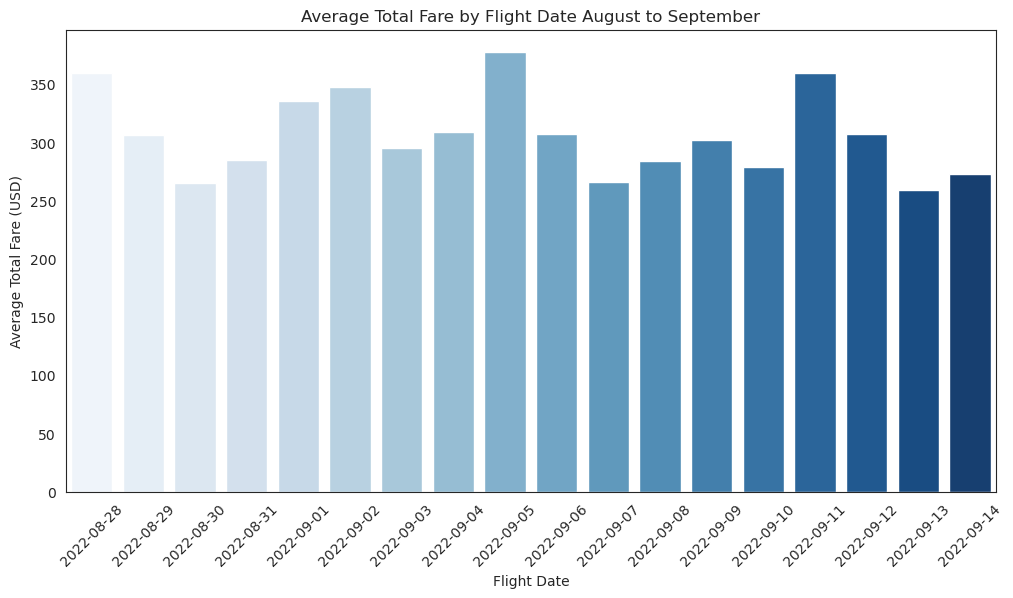

In [52]:
#total fare august-october bar graph
filtered_df = sampled_df.where((col('flightDate') >= '2022-08-28') & (col('flightDate') <= '2022-09-14'))
agg_data = filtered_df.groupBy('flightDate').agg({'totalFare': 'avg'}).toPandas()
agg_data['flightDate'] = pd.to_datetime(agg_data['flightDate'])

#sorting by flightDate in ascending order
agg_data = agg_data.sort_values('flightDate', ascending=True)

# Plotting graph
plt.figure(figsize=(12, 6))
sns.barplot(x='flightDate', y='avg(totalFare)', data=agg_data, palette='Blues')
plt.title('Average Total Fare by Flight Date August to September')
plt.xlabel('Flight Date')
plt.ylabel('Average Total Fare (USD)')
plt.xticks(rotation=45)
plt.show()

In [53]:
img_data.seek(0)
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-bigdata-project-ma')
blob = bucket.blob("fare_by_flight_date_Aug_Sep_plot.png")
blob.upload_from_file(img_data)
plt.close()

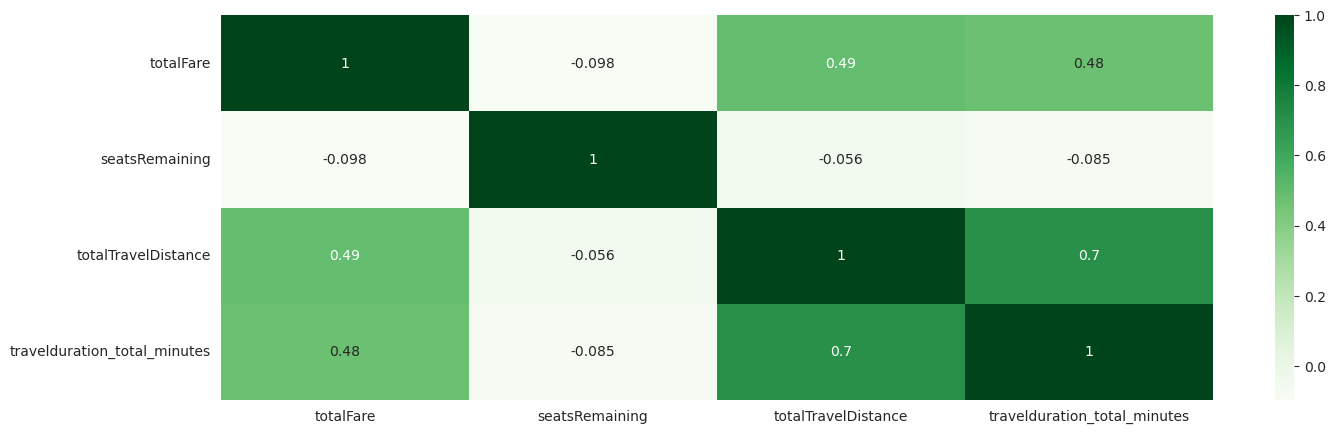

In [58]:
#correlation matrix
from pyspark.ml.stat import Correlation

vector_column = "correlation_features"
# Choose the numeric (Double) columns
numeric_columns = ['totalFare', 'seatsRemaining', 'totalTravelDistance', 'travelduration_total_minutes']

assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(sampled_df).select(vector_column)

#creating correlation matrix
matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist()

correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=numeric_columns, index=numeric_columns)

sns.set_style("white")
heatmap_plot = plt.figure(figsize=(16, 5))
sns.heatmap(correlation_matrix_df, 
            xticklabels=correlation_matrix_df.columns.values,
            yticklabels=correlation_matrix_df.columns.values, cmap="Greens", annot=True)

plt.savefig("correlation_matrix.png")

In [59]:
img_data = io.BytesIO()
heatmap_plot.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-bigdata-project-ma')
blob = bucket.blob("correlation_matrix_1_plot.png")
blob.upload_from_file(img_data)

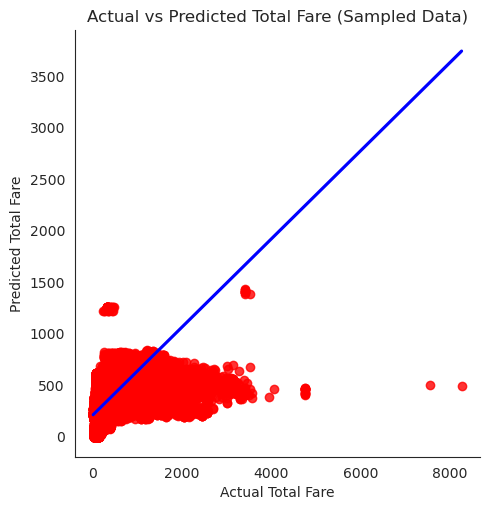

In [60]:
sample_df = test_results.select('totalFare', 'prediction').sample(fraction=0.1, seed=42).toPandas()

sns.set_style("white")
sns.lmplot(x='totalFare', y='prediction', data=sample_df, line_kws={'color': 'blue'}, scatter_kws={'color': 'red'})

plt.title('Actual vs Predicted Total Fare (Sampled Data)')
plt.xlabel('Actual Total Fare')
plt.ylabel('Predicted Total Fare')

plt.show()